In [47]:
import time

import torch
from torch_geometric.data import Data
from torch_geometric.utils import degree

from custom.utils import *

In [48]:
def create_subgraphs(pattern, graph1, graph2):
    g1_nodes = set()
    g2_nodes = set()
    for g1_node, g2_node in pattern.items():
        g1_nodes.add(g1_node)
        g2_nodes.add(g2_node)

    g1_node_map = {node: idx for idx, node in enumerate(g1_nodes)}
    g2_node_map = {node: idx for idx, node in enumerate(g2_nodes)}

    g1_edge_index = []
    for edge in graph1.edge_index.t():
        if edge[0].item() in g1_nodes and edge[1].item() in g1_nodes:
            g1_edge_index.append(
                [g1_node_map[edge[0].item()], g1_node_map[edge[1].item()]]
            )

    g2_edge_index = []
    for edge in graph2.edge_index.t():
        if edge[0].item() in g2_nodes and edge[1].item() in g2_nodes:
            g2_edge_index.append(
                [g2_node_map[edge[0].item()], g2_node_map[edge[1].item()]]
            )

    g1_subgraph = Data(
        x=graph1.x[list(g1_nodes)],
        edge_index=torch.tensor(g1_edge_index, dtype=torch.long).t().contiguous(),
        original_node_ids=torch.tensor(list(g1_nodes), dtype=torch.long),
    )
    g2_subgraph = Data(
        x=graph2.x[list(g2_nodes)],
        edge_index=torch.tensor(g2_edge_index, dtype=torch.long).t().contiguous(),
        original_node_ids=torch.tensor(list(g2_nodes), dtype=torch.long),
    )

    return g1_subgraph, g2_subgraph


def print_patterns(patterns, graph1, graph2):
    for i in patterns:
        g1_subgraph, g2_subgraph = create_subgraphs(i, graph1, graph2)

        if nx.is_isomorphic(
            to_networkx(g1_subgraph, to_undirected=True),
            to_networkx(g2_subgraph, to_undirected=True),
        ):

            plot_mutag(
                g1_subgraph,
                g2_subgraph,
                perm1=g1_subgraph.original_node_ids,
                perm2=g2_subgraph.original_node_ids,
            )

In [49]:
def mutual_pairs(attention_nodes, i=0):
    outer_layer = attention_nodes[i]
    g1_attention, g2_attention = outer_layer

    mutual_pairs = []

    for g1_node, g1_attends in enumerate(g1_attention):
        for g2_node in g1_attends:
            if g1_node in g2_attention[g2_node]:
                pair = (g1_node, g2_node)
                if pair not in mutual_pairs:
                    mutual_pairs.append(pair)

    random.shuffle(mutual_pairs)
    return mutual_pairs


class VF2MCS:
    def __init__(self, mp, time_limit=60):
        self.max_depth = 0
        self.time_limit = time_limit
        self.start_time = None
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        self.mp = mp

    def find_mcs(self, G1, G2, max_depth=1000):
        self.max_size = 0
        self.all_mappings = []
        self.unique_mappings = set()
        M = {}
        self.max_depth = max_depth
        self.start_time = time.time()

        G1_degrees = degree(G1.edge_index[0], G1.num_nodes)
        G2_degrees = degree(G2.edge_index[0], G2.num_nodes)

        self.match(G1, G2, M, G1_degrees, G2_degrees, 0)
        return self.all_mappings

    def match(self, G1, G2, M, G1_degrees, G2_degrees, depth):
        if time.time() - self.start_time > self.time_limit:
            return

        if len(M) > self.max_size:
            self.max_size = len(M)
            self.all_mappings = [M.copy()]
            self.unique_mappings = {self.canonical_form(M)}
        elif len(M) == self.max_size:
            canonical = self.canonical_form(M)
            if canonical not in self.unique_mappings:
                self.all_mappings.append(M.copy())
                self.unique_mappings.add(canonical)

        if depth >= self.max_depth:
            return

        nodes1 = sorted(range(G1.num_nodes), key=lambda n: -G1_degrees[n].item())
        nodes2 = sorted(range(G2.num_nodes), key=lambda n: -G2_degrees[n].item())

        for n1 in nodes1:
            if n1 not in M:
                for n2 in nodes2:
                    if n2 not in M.values() and self.feasible(
                        n1, n2, M, G1, G2, G1_degrees, G2_degrees
                    ):
                        M[n1] = n2
                        self.match(G1, G2, M, G1_degrees, G2_degrees, depth + 1)
                        del M[n1]

    def feasible(self, n1, n2, M, G1, G2, G1_degrees, G2_degrees):
        if (not torch.equal(G1.x[n1], G2.x[n2])) or (not (n1, n2) in self.mp):
            return False
        if G1_degrees[n1].item() > G2_degrees[n2].item():
            return False

        for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]:
            if (
                neighbor.item() in M
                and not (
                    G2.edge_index[1][G2.edge_index[0] == n2] == M[neighbor.item()]
                ).any()
            ):
                return False

        G1_edges = set(
            (min(n1, n2), max(n1, n2))
            for n1, n2 in zip(G1.edge_index[0].tolist(), G1.edge_index[1].tolist())
        )
        G2_edges = set(
            (min(n1, n2), max(n1, n2))
            for n1, n2 in zip(G2.edge_index[0].tolist(), G2.edge_index[1].tolist())
        )
        mapped_edges = set(
            (min(M[n1], M[n2]), max(M[n1], M[n2]))
            for n1, n2 in G1_edges
            if n1 in M and n2 in M
        )

        if not all(edge in G2_edges for edge in mapped_edges):
            return False

        G1_in = {
            neighbor.item()
            for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]
            if neighbor.item() in M
        }
        G2_in = {M[neighbor] for neighbor in G1_in}
        G1_out = {
            neighbor.item()
            for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]
            if neighbor.item() not in M
        }
        G2_out = {
            neighbor.item()
            for neighbor in G2.edge_index[1][G2.edge_index[0] == n2]
            if neighbor.item() not in M.values()
        }

        if len(G1_in) > len(G2_in) or len(G1_out) > len(G2_out):
            return False

        # Ensure that both graphs have the same structure (cycles included)
        G1_neighbors = {
            neighbor.item() for neighbor in G1.edge_index[1][G1.edge_index[0] == n1]
        }
        G2_neighbors = {
            neighbor.item() for neighbor in G2.edge_index[1][G2.edge_index[0] == n2]
        }
        for neighbor in G1_neighbors:
            if neighbor in M and M[neighbor] not in G2_neighbors:
                return False

        return True

    def canonical_form(self, mapping):
        return tuple(sorted(mapping.items()))

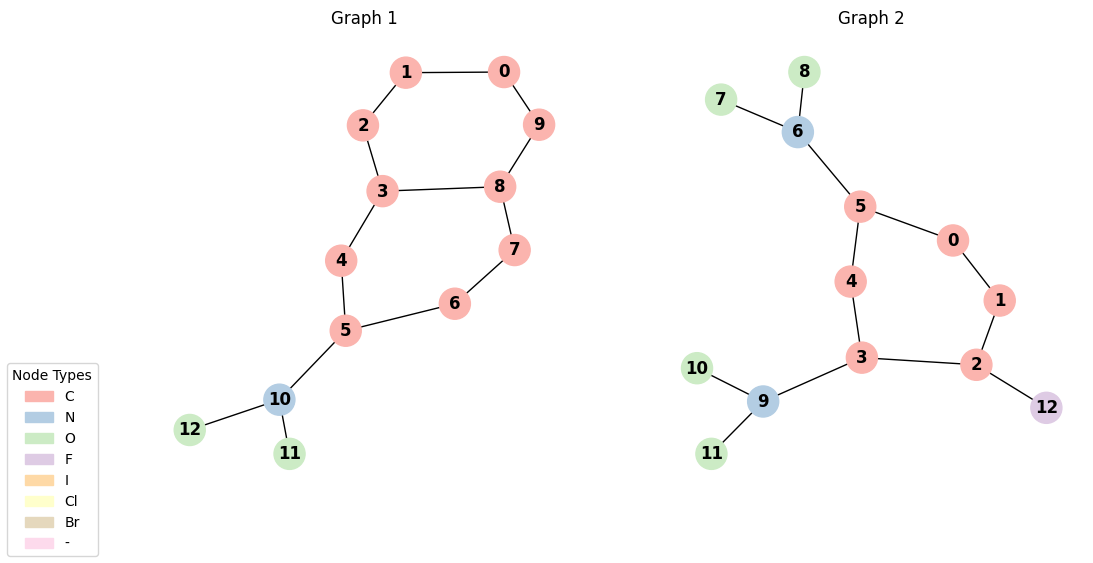

In [50]:
(graph1, graph2, attention_nodes) = torch.load("info.pt")
mp_0 = mutual_pairs(attention_nodes, 0)

vf2 = VF2MCS(mp_0, time_limit=60)

plot_mutag(graph1, graph2)

Largest Common Subgraph Mapping: [{10: 6, 11: 7, 12: 8}, {10: 6, 11: 8, 12: 7}, {10: 9, 11: 10, 12: 11}, {10: 9, 11: 11, 12: 10}]
Time taken: 0.13133001327514648 seconds


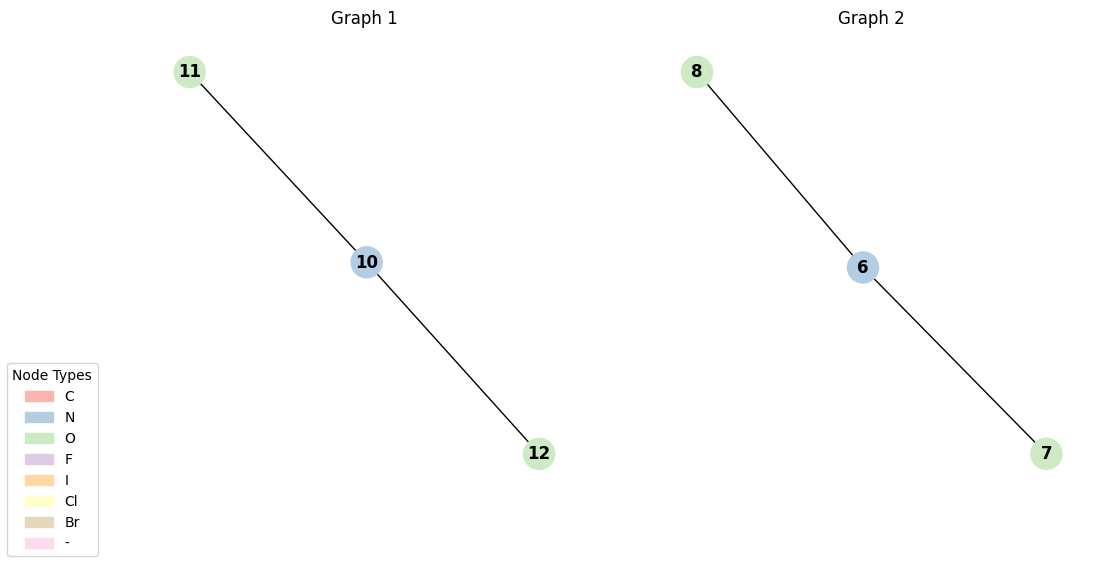

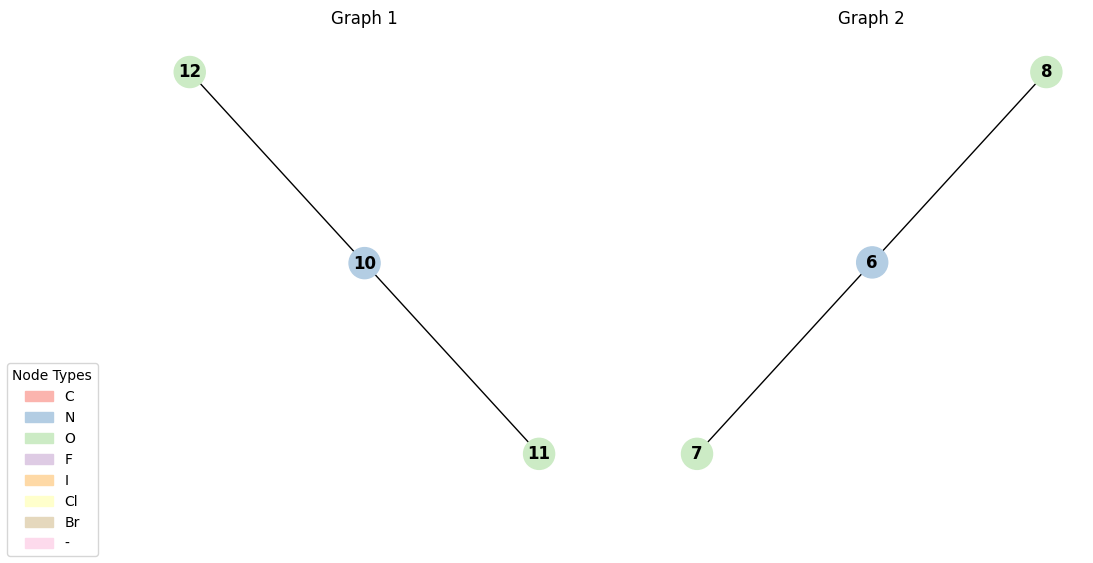

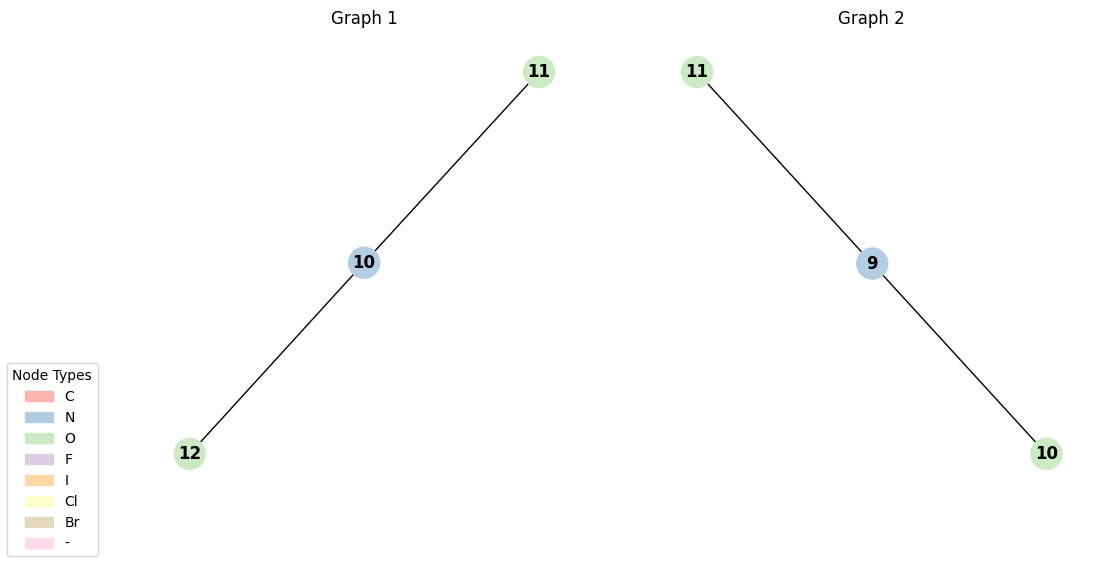

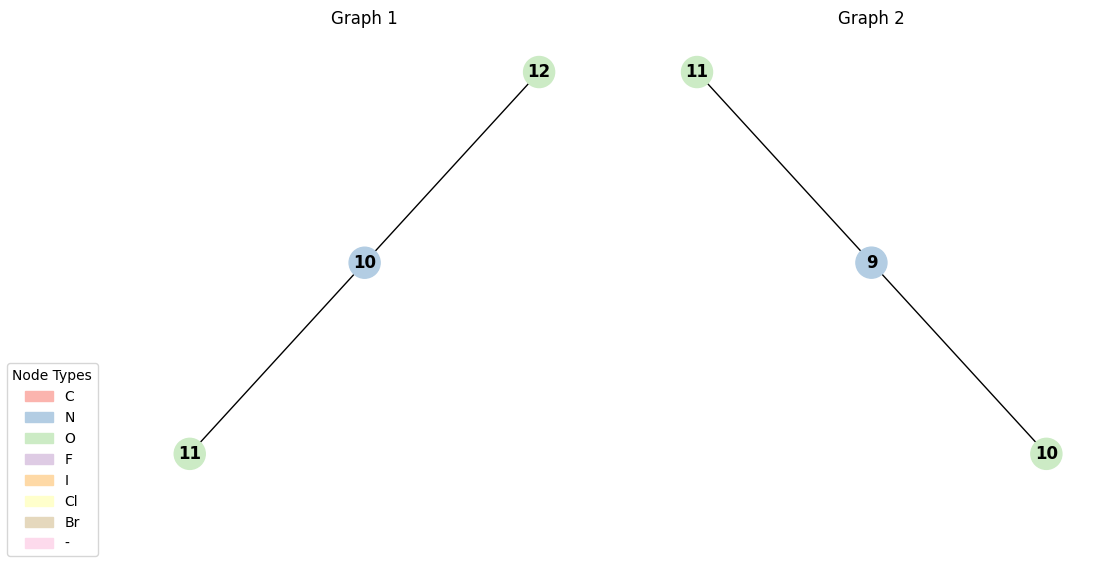

In [51]:
start_time = time.time()
mcs = vf2.find_mcs(graph1, graph2, max_depth=10)
end_time = time.time()

print("Largest Common Subgraph Mapping:", mcs)
print("Time taken:", end_time - start_time, "seconds")
print_patterns(mcs, graph1, graph2)

In [52]:
nodes_1 = []
nodes_2 = []
for m in mcs:
    nodes_1.extend(list(m.keys()))
    nodes_2.extend(list(m.values()))

nodes_1 = set(nodes_1)
nodes_2 = set(nodes_2)

print(nodes_1, nodes_2)

mp_1 = mutual_pairs(attention_nodes, 1)

for n1, n2 in mp_1:
    if n1 in nodes_1:
        mp_1.remove((n1, n2))

for n1, n2 in mp_1:
    if n2 in nodes_2:
        mp_1.remove((n1, n2))

print(mp_1)

{10, 11, 12} {6, 7, 8, 9, 10, 11}
[(7, 0), (3, 2), (9, 4), (0, 0), (9, 1), (7, 1), (8, 5), (2, 1), (0, 1), (1, 4), (0, 4), (3, 3), (2, 4), (8, 2), (3, 5), (6, 4), (7, 4), (2, 0), (5, 3), (5, 5), (4, 1), (1, 1), (8, 3), (4, 0), (4, 4), (1, 0), (5, 2), (6, 0), (6, 1), (9, 0)]


Largest Common Subgraph Mapping: [{3: 3, 5: 5, 8: 2, 4: 4, 6: 0, 7: 1}]
Time taken: 4.486721038818359 seconds


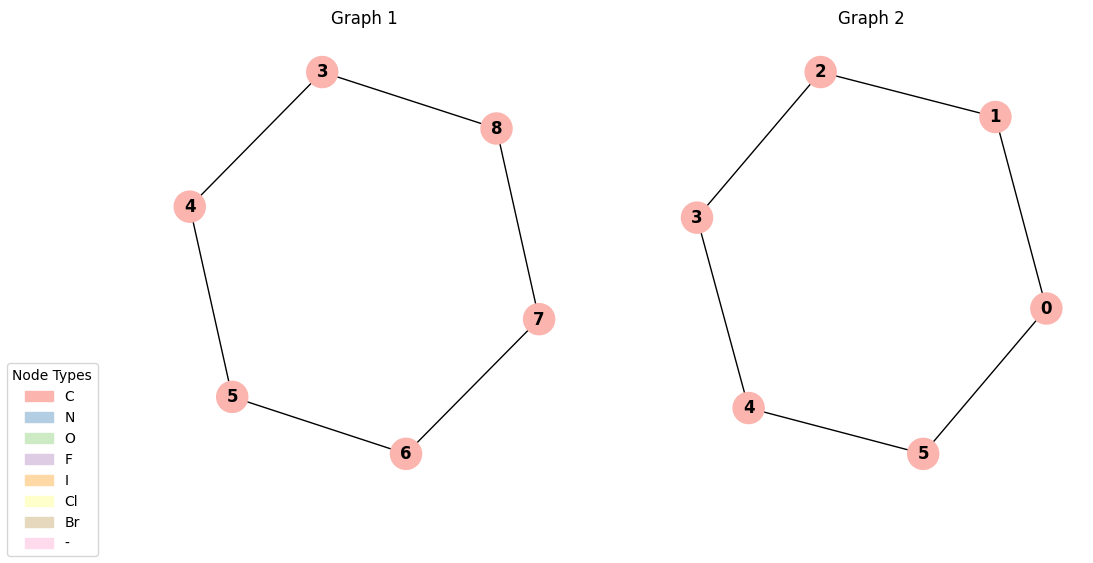

In [53]:
vf2 = VF2MCS(mp_1, time_limit=60)
start_time = time.time()
mcs = vf2.find_mcs(graph1, graph2, max_depth=10)
end_time = time.time()

print("Largest Common Subgraph Mapping:", mcs)
print("Time taken:", end_time - start_time, "seconds")
print_patterns(mcs, graph1, graph2)